# problem4

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [40]:
dataRaw = pd.read_csv(r".\incomeTaxData.csv")
dataRaw.head()

,Year,County,IncomeClass,Disclosure,ReturnCount,TotalIncome,TotalDeductions,TotalExemptions,TotalTaxableIncome,TotalTaxBeforeCredits,TotalTaxLiability,Place of Residence Sort Order,Income Class Sort Order
0,2011,Hamilton,"500,000 and over",d/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26,13
1,2003,Dutchess,"100,000 - 199,999",NaN,12738.0,1668991.0,261775.0,16628.0,1390589.0,91652.0,87689.0,19,10
2,2001,Ontario,Total,NaN,44898.0,1829734.0,449962.0,25393.0,1354378.0,77454.0,72764.0,38,12
3,2012,New York City - Richmond,"30,000 - 39,999",NaN,16086.0,559918.0,192402.0,10519.0,356997.0,17286.0,12238.0,5,5
4,2007,Clinton,"50,000 - 59,999",NaN,2197.0,120482.0,29429.0,1649.0,89404.0,4738.0,4220.0,15,7


You can see just from the first line of the dataset that the there are some rows with no returns associated with it. Let's delete those from the dataset.

Also note that all of the data is in thousands of dollars.

In [41]:
# clean data
data = dataRaw.dropna(subset=['ReturnCount'])
data = data.sort_values(by='Year')

# normalize County column
data["County"] = data["County"].apply(lambda x: x.strip())

# create new columns
data["avg_tax"] = data["TotalTaxLiability"] / data["ReturnCount"]

## a)

Plot the number of returns in Tompkins County over time.
（you should draw the plot for each income class and ignore the rows with the class of 'Total'.）

all classes: ['Under 5,000', '5,000 - 9,999', '10,000 - 19,999', '20,000 - 29,999', '30,000 - 39,999', '40,000 - 49,999', '50,000 - 59,999', '60,000 - 74,999', '75,000 - 99,999', '100,000 - 199,999', '200,000 - 249,999', '250,000 - 499,999', '500,000 and over']


Text(0, 0.5, 'return')

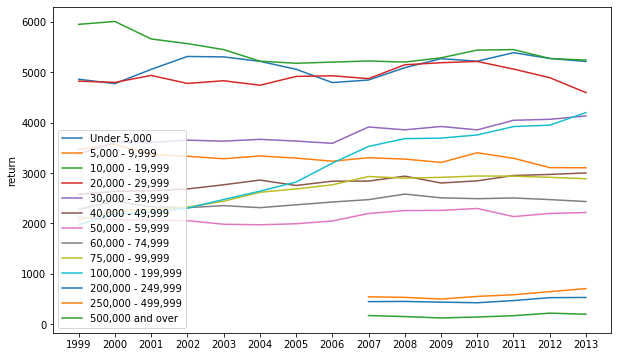

In [42]:
dataTompkins = data.loc[data["County"]=="Tompkins", ["Year", "IncomeClass", "ReturnCount", "avg_tax"]]
dataTompkins1 = dataTompkins.loc[dataTompkins["IncomeClass"] != "Total", ["Year", "IncomeClass", "ReturnCount"]]

dataTompkins1G = dataTompkins1.groupby(by=['IncomeClass'])
classes = list(dataTompkins1["IncomeClass"].unique())

#sort the classes logically
classes = classes[1:7]+classes[8:13]
classes = sorted(classes, key=lambda x: int(x.split('-')[0].replace(',', '')))
classes = ['Under 5,000'] + classes + ['500,000 and over']
print ("all classes:", classes)

tsEachClass = []

for cls in classes:
    dfCls = dataTompkins1G.get_group(cls)
    tsEachClass.append(dfCls)

f, ax = plt.subplots(figsize=(10, 6))
for cls, ts in zip(classes, tsEachClass):
    ax.plot(ts["Year"], ts["ReturnCount"], label=cls)
ax.legend()
ax.set_xticks(np.arange(1999, 2014))
ax.set_ylabel("return")

Plot the average income tax per return in Tompkins County (disregarding income tax).
（you could add up the all income classes (except 'Total') to calculate the weighted average tax OR just plot the rows of 'Total'. The added up number might be different with the number in 'total', and it should be fine.）

Text(0, 0.5, 'return')

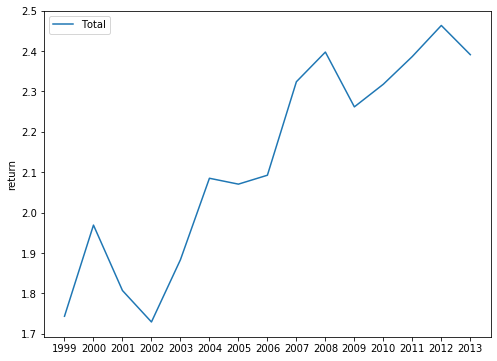

In [44]:
dataTompkins2 = dataTompkins.loc[dataTompkins['IncomeClass']=="Total", ["Year", "avg_tax"]]
f, ax = plt.subplots(figsize=(8, 6))
ax.plot(dataTompkins2['Year'], dataTompkins2['avg_tax'], label='Total')
ax.legend()
ax.set_xticks(np.arange(1999, 2014))
ax.set_ylabel("return")

What kind of plot did you choose to make? Why?

**my answer**

I use line chart here because they are time series.

## b)

Continuing to look only at Tompkins County, fit a model that predicts avg_tax using the year number. Do this with least squares.

w =  0.001061207752281709
mse =  0.05892504530157093


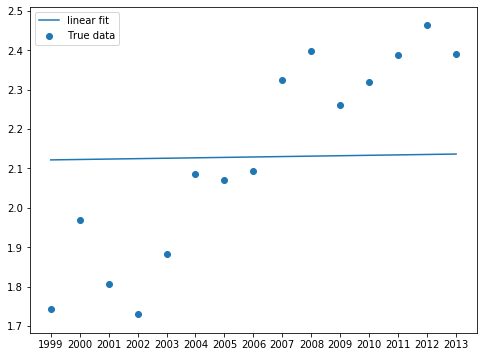

In [45]:
# avg_tax = w * year
y = np.array(dataTompkins2['avg_tax'])
X = np.array(dataTompkins2['Year'])
w,resid,rank,s = np.linalg.lstsq(X.reshape(-1, 1),y.reshape(-1, 1))
print ("w = ", w[0][0])
print ("mse = ", resid[0]/len(X))

x = np.linspace(1999, 2013, 100)
f,ax = plt.subplots(figsize=(8, 6))
ax.scatter(X, y, label='True data')
ax.plot(x, [w[0][0]*x_ for x_ in x], label='linear fit')
ax.set_xticks(np.arange(1999, 2014))
ax.legend()

Transform the input to include an offset term in the model

w1 =  0.05272998568827641 w0 =  -103.6480493391341
mse =  0.009091112016592897


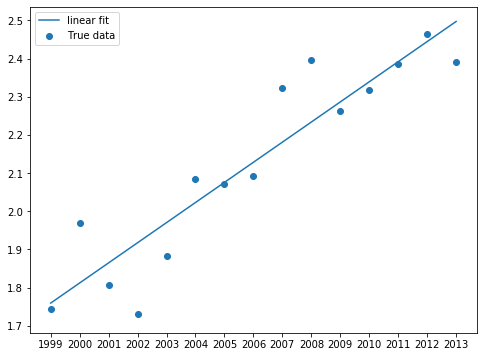

In [46]:
# avg_tax = w1 * year + w0
y = np.array(dataTompkins2['avg_tax'])
X = np.array(dataTompkins2['Year'])
X = np.vstack((X, np.ones_like(X))).T
w,resid,rank,s = np.linalg.lstsq(X, y.reshape(-1, 1))
print ("w1 = ", w[0][0], "w0 = ", w[-1][0])
print ("mse = ", resid[0]/len(X))

f,ax = plt.subplots(figsize=(8, 6))
ax.scatter(X[:,0], y, label='True data')
ax.plot(x, [w[0][0]*x_ + w[-1][0] for x_ in x], label='linear fit')
ax.set_xticks(np.arange(1999, 2014))
ax.legend()

## c)

Now we will change the feature space.
Fit a model using the year and the avg_tax from the previous year.

In [47]:
dataTompkins2["avg_tax_b1"] = dataTompkins2["avg_tax"].shift(1)
dataTompkins2 = dataTompkins2.dropna()

In [48]:
# avg_tax = w2 * avg_tax_b1 + w1 * year + w0
y = np.array(dataTompkins2['avg_tax'])
X = np.array(dataTompkins2.iloc[:, [0, 2]])
X = np.vstack((X.T, np.ones(len(y)))).T
w,resid,rank,s = np.linalg.lstsq(X, y.reshape(-1, 1))
print ("w0 = ", w[2], "w1 = ", w[0], "w2 = ", w[1])
print ("mse = ", resid[0]/len(X))

wc = w

w0 =  [-81.45539241] w1 =  [0.04146927] w2 =  [0.19107589]
mse =  0.00940059825671284


Interpret the coefficients of this. What do they mean?

Plot the real average tax return per year against your model's prediction. Discuss how you think your model fits.

**my answer**

The fitted model is avg_tax = 0.191*avg_tax_b1 + 0.041*year -81.455
It means if avg_tax_b1 increase 1 unit, the avg_tax will increase 0.191 unit and on average, this year's avg_tax is 0.041 more than that of last year.

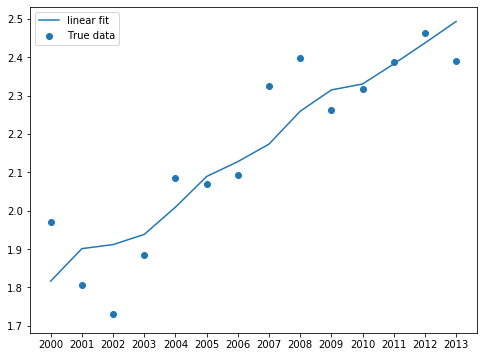

In [49]:
f,ax = plt.subplots(figsize=(8, 6))
ax.scatter(X[:,0], y, label='True data')
ax.plot(X[:,0], np.dot(X, w), label='linear fit')
ax.set_xticks(np.arange(2000, 2014))
ax.legend()

**my answer**

Even though the mse get larger, this model fits better than that in b. As you can see in the figure above, the model learned some turning point, like 2001, 2010

## d)

Add two new features to your model. This could be a column of the data, a transformation of a column, or a new column formed from another. The only requirement is that the prediction in year $t$ be based on data avilable by the end of year $t-1$

Fit this model and interpret the coefficients. 

In [51]:
dataTompkins = data.loc[(data["County"]=="Tompkins") & (data["IncomeClass"]=='Total'), :]
dataTompkins = dataTompkins.iloc[:, [0, 4, 5, 6, 7, 8, 9, 10, 13]]
dataTompkins['avg_tax_b1'] = dataTompkins['avg_tax'].shift(1)

#avoiding using future data, do shifting in features
dataTompkins.iloc[:, range(1, 8)] = dataTompkins.iloc[:, range(1, 8)].shift(1)
dataTompkins = dataTompkins.dropna()

#a lot of choices to be new features, have a correlation analysis first
dataTompkins.corr()

,Year,ReturnCount,TotalIncome,TotalDeductions,TotalExemptions,TotalTaxableIncome,TotalTaxBeforeCredits,TotalTaxLiability,avg_tax,avg_tax_b1
Year,1.000000,0.960708,0.943927,0.963217,-0.315272,0.941851,0.957635,0.947824,0.905601,0.924948
ReturnCount,0.960708,1.000000,0.954557,0.959719,-0.166658,0.957268,0.972945,0.970235,0.865039,0.937910
TotalIncome,0.943927,0.954557,1.000000,0.976507,-0.239625,0.999014,0.993245,0.991620,0.892584,0.989423
TotalDeductions,0.963217,0.959719,0.976507,1.000000,-0.197083,0.969043,0.979038,0.964841,0.927335,0.952233
TotalExemptions,-0.315272,-0.166658,-0.239625,-0.197083,1.000000,-0.242883,-0.190048,-0.190563,-0.211154,-0.187130
TotalTaxableIncome,0.941851,0.957268,0.999014,0.969043,-0.242883,1.000000,0.993154,0.993861,0.881472,0.990551
TotalTaxBeforeCredits,0.957635,0.972945,0.993245,0.979038,-0.190048,0.993154,1.000000,0.997658,0.897670,0.990166
TotalTaxLiability,0.947824,0.970235,0.991620,0.964841,-0.190563,0.993861,0.997658,1.000000,0.876583,0.993748
avg_tax,0.905601,0.865039,0.892584,0.927335,-0.211154,0.881472,0.897670,0.876583,1.000000,0.866742
avg_tax_b1,0.924948,0.937910,0.989423,0.952233,-0.187130,0.990551,0.990166,0.993748,0.866742,1.000000


In [88]:
#try to add TotalDeductions_b1 and TotalTaxableIncome_b1 as 2 new features
dataTompkinsd = dataTompkins.iloc[:, [0, 9, 3, 5, 8]]
X = dataTompkinsd.iloc[:, range(4)]
X = np.vstack((np.array(X).T, np.ones(len(X)))).T
y = np.array(dataTompkinsd["avg_tax"])

# avg_tax = w4 * TotalTaxableIncome_b1 + w3 * TotalDeductions_b1 + w2 * avg_tax_b1 + w1 * year + w0
w,resid,rank,s = np.linalg.lstsq(X, y.reshape(-1, 1))
print ("w0 = ", w[4], "w1 = ", w[0], "w2 = ", w[1], "w3 = ", w[2], "w4 = ", w[3])
print ("mse = ", resid[0]/len(X))
wd = w


w0 =  [-24.65435406] w1 =  [0.01221163] w2 =  [0.16662061] w3 =  [6.95410628e-06] w4 =  [-5.38556388e-07]
mse =  0.007109353697290108


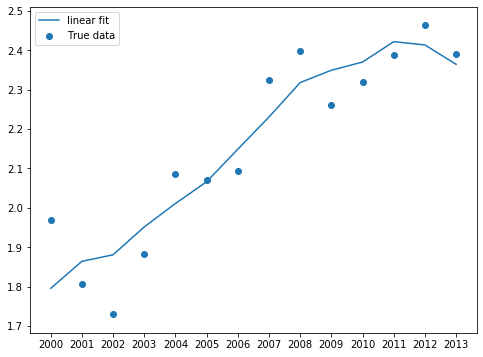

In [53]:
f,ax = plt.subplots(figsize=(8, 6))
ax.scatter(X[:,0], y, label='True data')
ax.plot(X[:,0], np.dot(X, w), label='linear fit')
ax.set_xticks(np.arange(2000, 2014))
ax.legend()

**my answer**

My new model:avg_tax = w4 * TotalTaxableIncome_b1 + w3 * TotalDeductions_b1 + w2 * avg_tax_b1 + w1 * year + w0
I predict the model will fit better because of the correlation analysis. In fact, the mse decreased from 0.009 to 0.007 and we can see the model fits very well after 2008.

## e)

Compare the coefficients from part c and d. Does the coefficient of avg_tax differ in the two models? If so, how do you interpret this difference?

**my answer**

Yes, they are different, 0.191, 0.167 in c,d respectively. This difference is caused by the new 2 features and the avg_tax_b1 are (positively) correlated, so some of the avg_tax_b1's impact on avg_tax is taken away by the new features

## f)

Now we want to see how this model performs in other counties. Apply the model you fit in part c, with coefficients $w^c$, to data from the other counties and compute the error of this model on each data set.

Plot a histogram of the mean errors the model makes.

In [76]:
counties = list(data['County'].unique()) #county list
#counties.remove("Tompkins")

#only focusing on other counties and IncomeClass of Total
dataf = data.loc[(data["IncomeClass"] == "Total"), :]

featC = ["Year", "avg_tax"]

def getMse(df, w=wc):
    X = df.drop("avg_tax", axis=1)
    y = df["avg_tax"]
    X = np.vstack((np.array(X).T, np.ones(len(df)))).T
    resids = np.array(y).reshape(-1, 1) - np.dot(X, w)
    mse = (resids**2).sum()/len(df)
    return mse

def testGeneralize(colsOrder=dataTompkins2.columns, feat=featC, w=wc):
    mses = dict() #store mean errors of each county
    for ct in counties:
        dataCt = dataf.loc[dataf["County"] == ct, feat]
        cond1 = len(dataCt) < 15
        cond2 = ct in ['NYS Unclassified +', 'Residence Unknown ++', 'Grand Total', 'Full-Year Resident.']
        if cond1 or cond2:#remove fake counties or counties haveing missing data 
            continue
        if len(feat) > 2:#other features should be shifted
            dataCt.loc[:, feat[2:]] = dataCt.loc[:, feat[2:]].shift(1)
        dataCt["avg_tax_b1"] = dataCt["avg_tax"].shift(1)
        dataCt = dataCt.dropna().loc[:, colsOrder]
        mses[ct] = getMse(dataCt, w)
    return mses

mses = testGeneralize()

finding those fitted well [('Orange', 0.007338703037527241), ('Tompkins', 0.009400598256713513), ('Albany', 0.011145964716924925)]
finding the outliers: [('Putnam', 1.0430448865418491), ('New York City - Bronx', 1.4529317326296598), ('Nassau', 3.831168062147247), ('Westchester', 14.439801423256265), ('New York City - Manhattan', 38.35204067775131)]


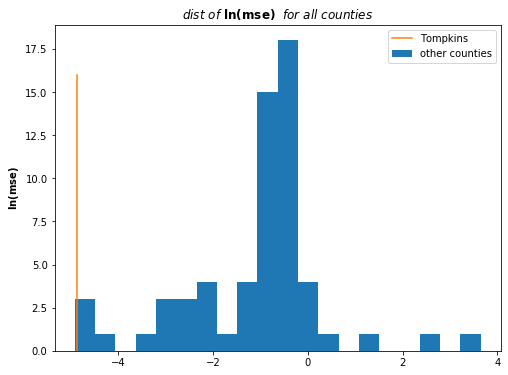

In [78]:
#to make the figure more readable, I use log(mse) rather than mse
f,ax = plt.subplots(figsize=(8, 6))
ax.hist([np.log(v) for v in mses.values()], bins=20, label='other counties')
ax.plot([np.log(0.0077)]*10, np.linspace(0, 16, 10), label='Tompkins')
ax.legend()
ax.set_title(r"$dist\ of\ \bf ln(mse)$ $\ for\ all\ counties$")
ax.set_ylabel(r"$\bf ln(mse)$")

import operator
sorted_mses = sorted(mses.items(), key=operator.itemgetter(1))
print ("finding those fitted well", sorted_mses[:3])
print ("finding the outliers:", sorted_mses[-5:])

Are there major outliers?

**my answer**

The mse of other counties except Orange should be higher. There are outliers. They are ('Nassau', 3.870409616631641), ('Westchester', 14.496649906729717), ('New York City - Manhattan', 38.381795728399354)

## g)

Using the same features you chose in part d, fit a model to the data for each of the other counties. These will be county-specific models. They may have different coefficient vectors from $w^d$.

Plot a histogram of the mean square errors of the county-specific models for their respective counties.

In [99]:
mses = dict()
ws = dict()
featD = ["Year", "avg_tax", "TotalDeductions", "TotalTaxableIncome"]
for ct in counties[:]:
    dataCt = dataf.loc[dataf["County"] == ct, featD]
    cond1 = len(dataCt) < 15
    cond2 = ct in ['NYS Unclassified +', 'Residence Unknown ++', 'Grand Total', 'Full-Year Resident.']
    if cond1 or cond2:#remove fake counties or counties haveing missing data 
        continue
    dataCt.loc[:, featD[2:]] = dataCt.loc[:, featD[2:]].shift(1)
    dataCt["avg_tax_b1"] = dataCt["avg_tax"].shift(1)
    dataCt = dataCt.dropna().loc[:, dataTompkinsd.columns]
    X = dataCt.drop("avg_tax", axis=1)
    y = np.array(dataCt["avg_tax"])
    X = np.vstack((np.array(X).T, np.ones(len(dataCt)))).T
    w,resid,rank,s = np.linalg.lstsq(X,y.reshape(-1, 1))
    ws[ct] = w
    mse = resid[0]/len(X)
    mses[ct] = mse

Text(0, 0.5, '$\\bf ln(mse)$')

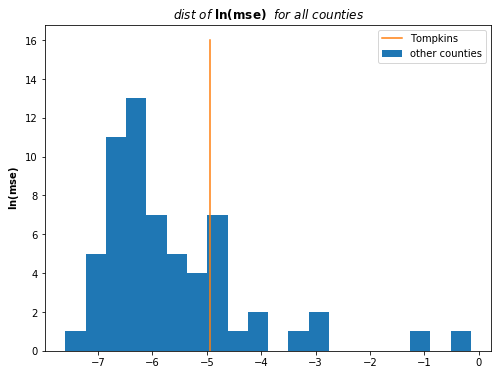

In [98]:
f,ax = plt.subplots(figsize=(8, 6))
ax.hist([np.log(v) for v in mses.values()], bins=20, label='other counties')
ax.plot([np.log(0.0071)]*10, np.linspace(0, 16, 10), label='Tompkins')
ax.legend()
ax.set_title(r"$dist\ of\ \bf ln(mse)$ $\ for\ all\ counties$")
ax.set_ylabel(r"$\bf ln(mse)$")

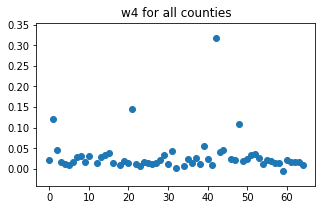

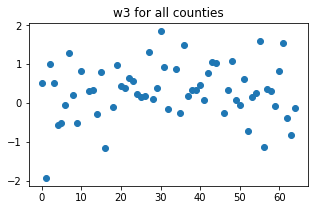

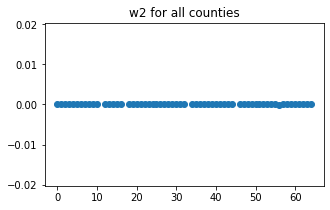

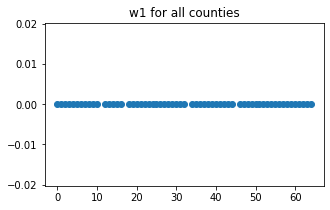

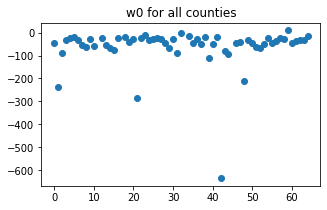

In [125]:
import pandas
coefs = pd.DataFrame(index=counties, columns=["w"+str(i) for i in range(5)])
for ct in ws.keys():
    coefs.loc[ct, :] = ws[ct].reshape(5, )

for i in range(5):
    data = coefs.iloc[:, i]
    f,ax = plt.subplots(figsize=(5, 3))
    ax.scatter(range(len(data)), data)
    ax.set_title("w"+str(4-i)+" for all counties")

Again, are there major outliers? How do the coefficients compare across counties?

**my answer**

The model's mse of more than half counties is smaller that that of Tompkins. The coefficients of the model for different counties are different. Whether different significantly depends on which pair of counties is being compared.

## h)

If you wanted to predict the income tax in each county in future years, do you think
the county-specic models or the Tompkins model would perform better? Why? What
concerns might you have about each model?

**my answer**

County-specific models will perform better, because differnt counties have different patterns as shown in questions above. 
Concerns: Even use county-specific model, since we are using previous data to predict future data, there will be some lag in prediction.

## i)

What other information would you want to use to make your model even better?

**my answer**

I think the meaning of every attribute and their logical relationship are important, it's better to understanding the data thoroughly before modelling. 
If there is information about tax policy change, the model will be better.

# problem5

$time\ spent\ on\ every\ problem:$<br>
$1 : 1.75h $<br>
$2 : 2h$<br>
$3 : 3h$<br>
$4 : 5h$<br>

$total: 12h$